# Face detection part
Using camera to detect face in real time.
The program will automatically record the current image when a face is detected.
After adjusting the resolution and color channel, the original image will be saved locally.
The image with face annotation will be displayed in notebook.

image save


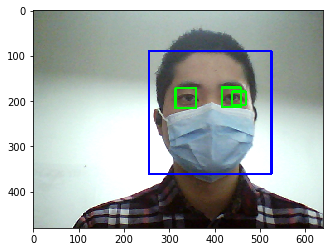

In [57]:
import cv2
from matplotlib import pyplot as plt  
import numpy as np

face_flag = True

frame_in_w = 640
frame_in_h = 480
# open the camera
cap = cv2.VideoCapture()
cap.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w)#set picture width
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h)#set hight
cap.open(0)
while (face_flag):
    ret, np_frame = cap.read()
    ret,test = cap.read()
    #import face data
    face_cascade = cv2.CascadeClassifier('data_face.xml')
    #import eye data
    eye_cascade = cv2.CascadeClassifier( 'data_eye.xml')
    # picture thransform to gray
    gray = cv2.cvtColor(np_frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    # detect face and eyes
    for (x,y,w,h) in faces:
        #draw rectangle
        cv2.rectangle(np_frame,(x,y),(x+w,y+h),(255,0,0),3)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = np_frame[y:y+h, x:x+w]

        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),3)
            i+=1
        if(i>2):  
            #print(eyes.shape)
            #------------------------------------------------
            #test resize
            test=cv2.resize(test,(1024,768))
#           print(img.shape)
            b,g,r = cv2.split(test)
            img_rgb = cv2.merge([r,g,b])
            cv2.imwrite('31.jpg',test)
            print("image save")
            #break while when detected face
            #------------------------------------------------   
            face_flag = False
            break


    # print the result picture
    get_ipython().magic('matplotlib inline') 
    plt.imshow(np_frame[:,:,[2,1,0]])
    plt.show()
    
# free cam,destroy window
cv2.destroyAllWindows()
cap.release()

# Load HLS Sobel image process part

In [58]:
from pynq import Overlay, GPIO, Register
from pynq import Xlnk
import numpy as np
import os
import inspect
class streamOverlay(Overlay):

    __RESET_VALUE = 0
    __NRESET_VALUE = 1

    __FILT1D_AP_CTRL_OFF = 0x00
    __FILT1D_AP_CTRL_START_IDX = 0
    __FILT1D_AP_CTRL_DONE_IDX  = 1
    __FILT1D_AP_CTRL_IDLE_IDX  = 2
    __FILT1D_AP_CTRL_READY_IDX = 3

    __FILT1D_GIE_OFF     = 0x04
    __FILT1D_IER_OFF     = 0x08
    __FILT1D_ISR_OFF     = 0x0C
    __FILT1D_COEFF_OFFS  = [0x10, 0x18, 0x20, 0x28,
                            0x30, 0x38, 0x40, 0x48,
                            0x50]
    __FILT1D_OPTION_OFF  = 0x58
    def __init__(self, bitfile, **kwargs):

        file_path = os.path.abspath(inspect.getfile(inspect.currentframe()))
        dir_path = os.path.dirname(file_path)
        bitfile = os.path.join(dir_path, bitfile)
        super().__init__(bitfile, **kwargs)
        self.__resetPin = GPIO(GPIO.get_gpio_pin(0), "out")
        self.__ap_ctrl = Register(self.image_process_0.mmio.base_addr, 32)
        self.xlnk = Xlnk()
        
    def __start(self):
        """Raise AP_START and enable the HLS core

        """
        self.__ap_ctrl[self.__FILT1D_AP_CTRL_START_IDX] = 1
        pass

    def __stop(self):
        """Lower AP_START and disable the HLS core

        """
        self.__ap_ctrl[self.__FILT1D_AP_CTRL_START_IDX] = 0
        pass

    def nreset(self):
        """Set the reset pin to self.__NRESET_VALUE to place the core into
        not-reset (usually run)

        """
        self.__resetPin.write(self.__NRESET_VALUE)
        
    def reset(self):
        """Set the reset pin to self.__RESET_VALUE to place the core into
        reset

        """
        self.__resetPin.write(self.__RESET_VALUE)

    def run(self, coeffs, buf):
        """ Launch computation on the HLS core

        Parameters
        ----------
        coeffs: list
            A 9-element python list to transfer to the HLS Core for use
        as filter coefficients.
    
        buf : list
            An xlnk allocated buffer to be transferred to the core
        """
        self.nreset()
        l = len(buf)
        self.__load(coeffs)
        cmabuf_src = self.xlnk.cma_array([l], np.int32)
        for i in range(l):
            cmabuf_src[i] = buf[i]
        cmabuf_dest = self.xlnk.cma_array([l], np.int32)
        # Initiate a transaction on the recieve channel (FPGA -> ARM) of the DMA engine
        self.axi_dma_0.recvchannel.transfer(cmabuf_dest)
        # Initiate a transaction on the transmit channel (ARM -> FPGA) of the DMA engine
        self.axi_dma_0.sendchannel.transfer(cmabuf_src)
        self.__start()
        self.axi_dma_0.sendchannel.wait()
        self.axi_dma_0.recvchannel.wait()
        self.__stop()
        buf = cmabuf_dest.tolist()
        cmabuf_dest.freebuffer()
        cmabuf_src.freebuffer()
        return buf

    def __load(self, coeffs):
        """ Load the filter coefficients and signal length into the HLS core 

        Parameters
        ----------
        coeffs : list
            A list of coefficients to load into the core filter registers.
    
        leng : int
            The length of the signal to perform a filtering operation on

        """
        for (offset, coeff) in zip(self.__FILT1D_COEFF_OFFS, coeffs):
            self.image_process_0.write(offset, coeff)



overlay = streamOverlay('design_1.bit')
get_ipython().magic('pinfo overlay')




# Display the Sobel processed image part

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0xAB748F10>
<PIL.Image.Image image mode=L size=1024x768 at 0xB5429AD0>


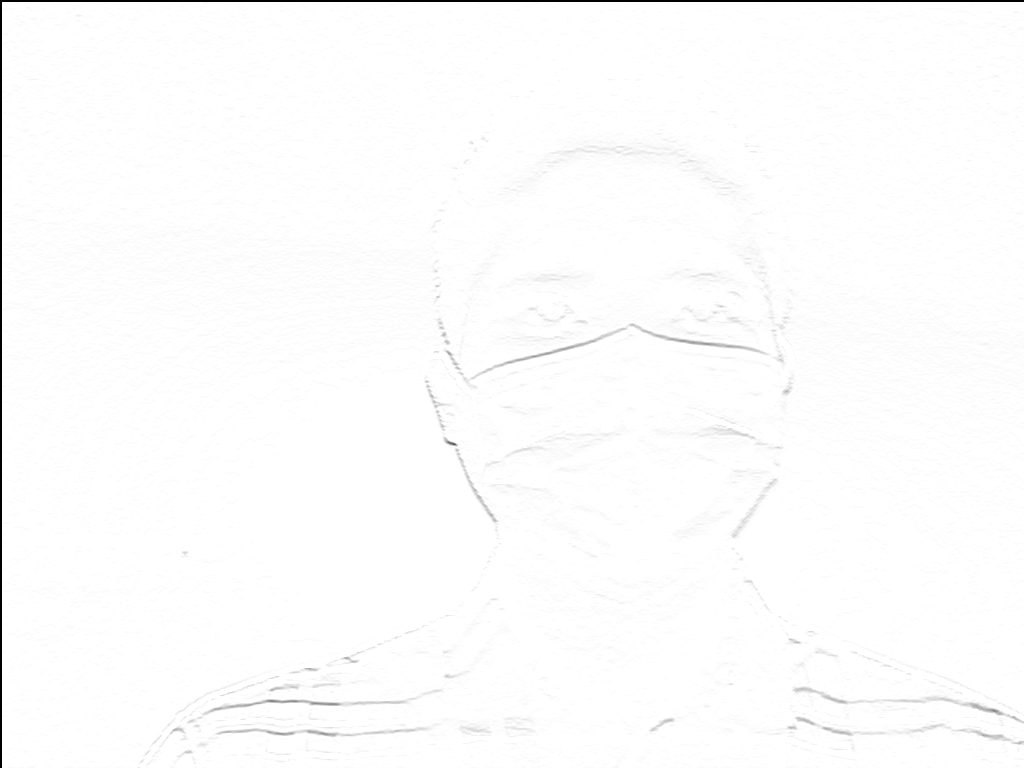

In [59]:
from PIL import Image


#gb = cv2.imread('image.jpg')
#rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

rgb = Image.open("31.jpg")
print(rgb)
bw = rgb.convert("L")
print(bw)
rgb


coeffs = [-1, -2, -1,
             0,  0,  0,
             1,  2,  1]

sig = list(bw.getdata())

# do soble
output = overlay.run(coeffs, sig)
out = Image.new('RGB', bw.size)
out.putdata(output)
out
